In [10]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

plt.jet()

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [17]:
dataFolder = './'
df = pd.read_excel(dataFolder+'gmt3_final_forces_english.xlsx', skiprows=2)
nact = len(df)
print('Number of actuators = ', nact)

Number of actuators =  170


In [16]:
df

,act #,LS type,x_opt (in),y_opt (in),f_FEM (lbs),f_active (lbs),f_FEM+f_active (lbs),newquad_corr (lbs),gmto_zfrc (lbs)
0,101,TA,-0.000559,-30.58141,201.150925,7.084308,208.235232,0.0,208.235232
1,102,TA,-0.000185,-56.79406,224.518482,6.094627,230.613109,0.0,230.613109
2,103,TA,0.000184,-83.00670,228.737195,-1.573539,227.163657,0.0,227.163657
3,104,TA,-0.000304,-109.21980,234.534074,-6.584757,227.949317,0.0,227.949317
4,105,TA,0.000059,-135.43250,243.606368,-2.657327,240.949041,0.0,240.949041
...,...,...,...,...,...,...,...,...,...
165,1335,D,110.315000,94.92300,159.874566,-0.187590,159.686976,0.0,159.686976
166,1212,D,-21.269490,154.76640,202.238838,3.545953,205.784792,0.0,205.784792
167,1235,D,-110.315000,94.92300,160.151122,3.991052,164.142174,0.0,164.142174
168,1412,D,21.274950,-154.76570,202.383838,4.564636,206.948473,0.0,206.948473


In [47]:
lbs2N = 4.4482216153
in2mm = 25.4
sax = np.array(df['y_opt (in)'])*in2mm/1000 #swap x/y to get to M1B (M1DCS uses M1B!!!)
say = np.array(df['x_opt (in)'])*in2mm/1000
f_FEM = np.array(df['f_FEM (lbs)'])*lbs2N
f_active = np.array(df['f_active (lbs)'])*lbs2N
f_quad = np.array(df['newquad_corr (lbs)'])*lbs2N
f_corr = np.array(df['gmto_zfrc (lbs)'])*lbs2N
saID = np.array(df['act #'])

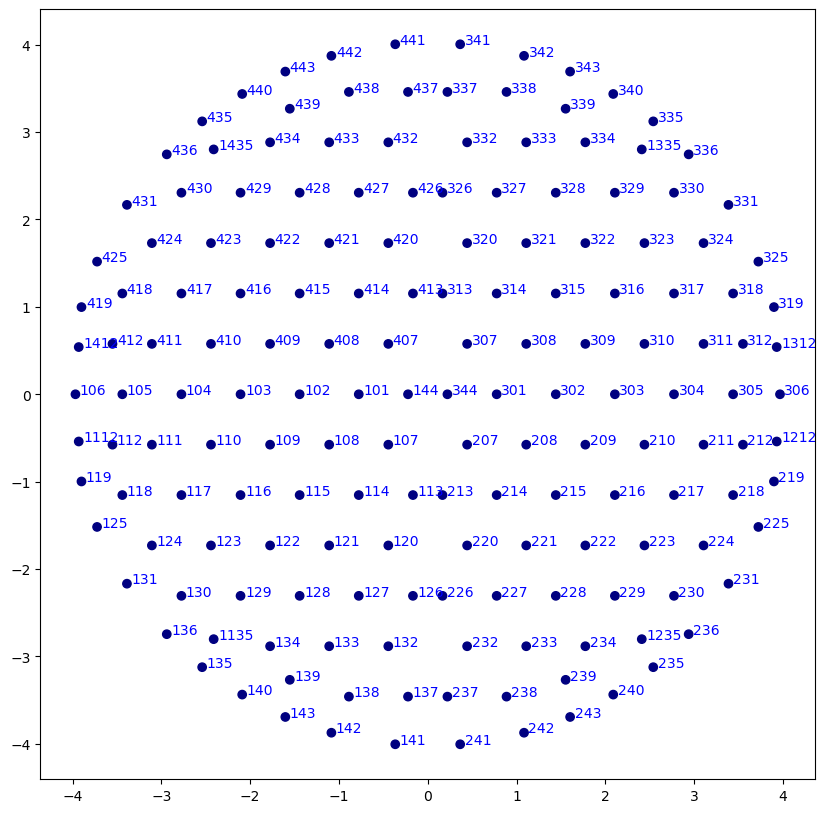

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(sax, say, c=np.ones(170))
for i in range(len(sax)):
    if (np.any(abs(sax[i]+say[i]-sax[:i]-say[:i])<1e-4)):
        plt.text(sax[i]+.05, say[i]-0.15, str(saID[i]),color='r')
    else:
        plt.text(sax[i]+.05, say[i], str(saID[i]),color='b')

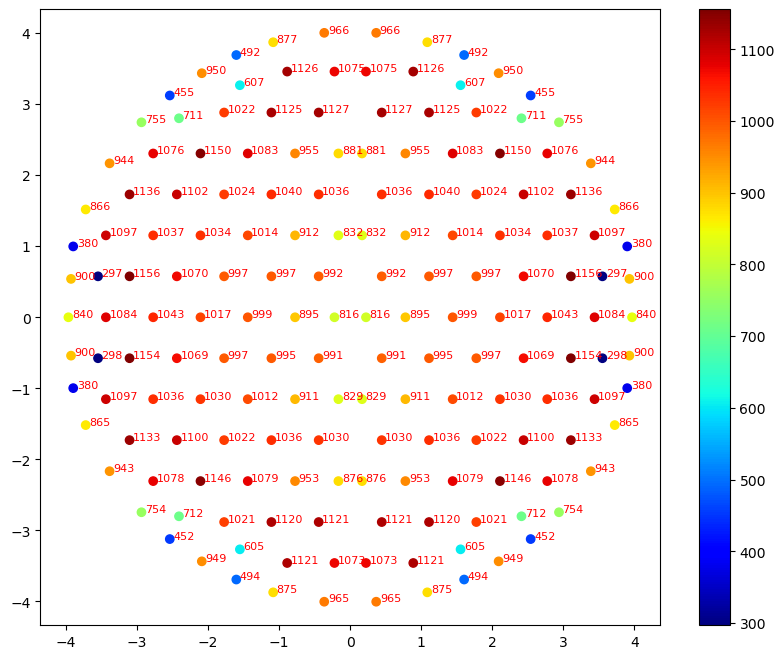

In [49]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(sax, say, c=f_FEM)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%f_FEM[i],color='r',fontsize=8)

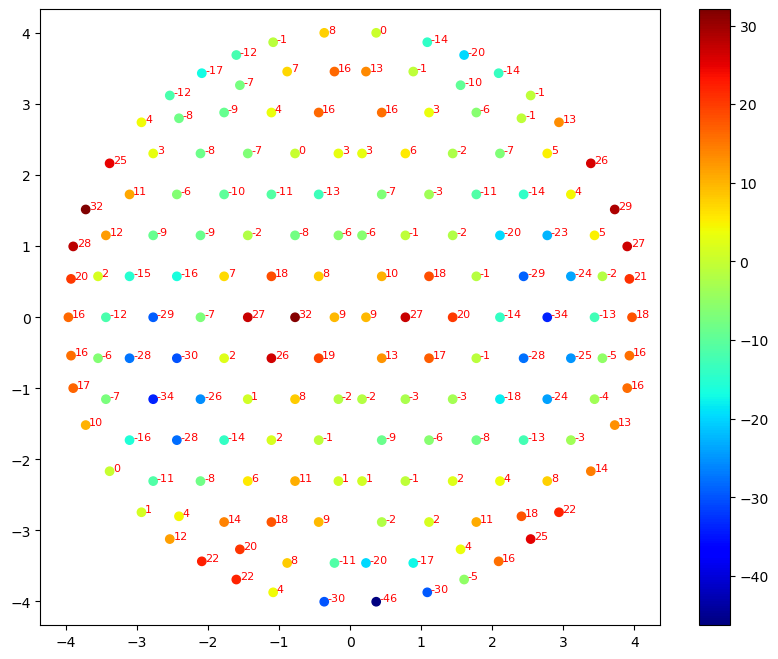

In [50]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(sax, say, c=f_active)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%f_active[i],color='r',fontsize=8)

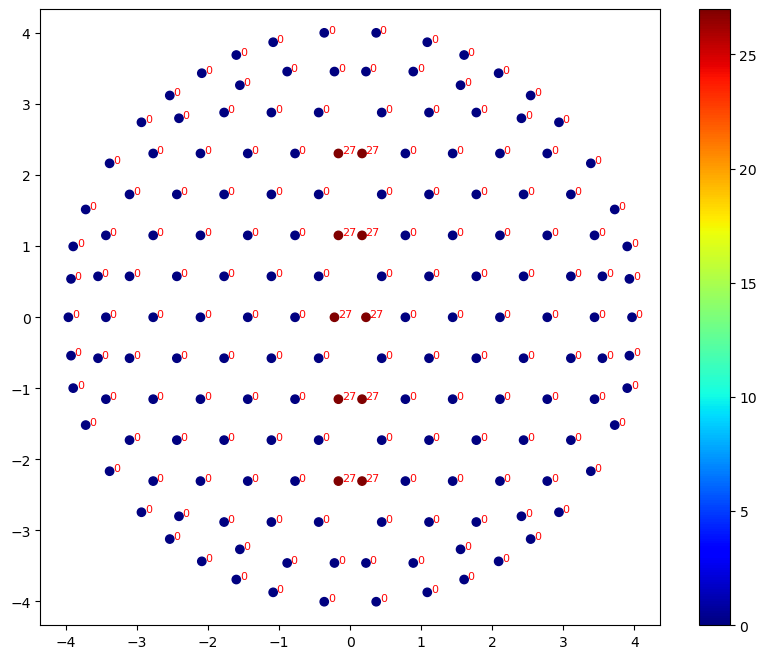

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(sax, say, c=f_quad)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%f_quad[i],color='r',fontsize=8)

Text(0, 0.5, 'y in meter')

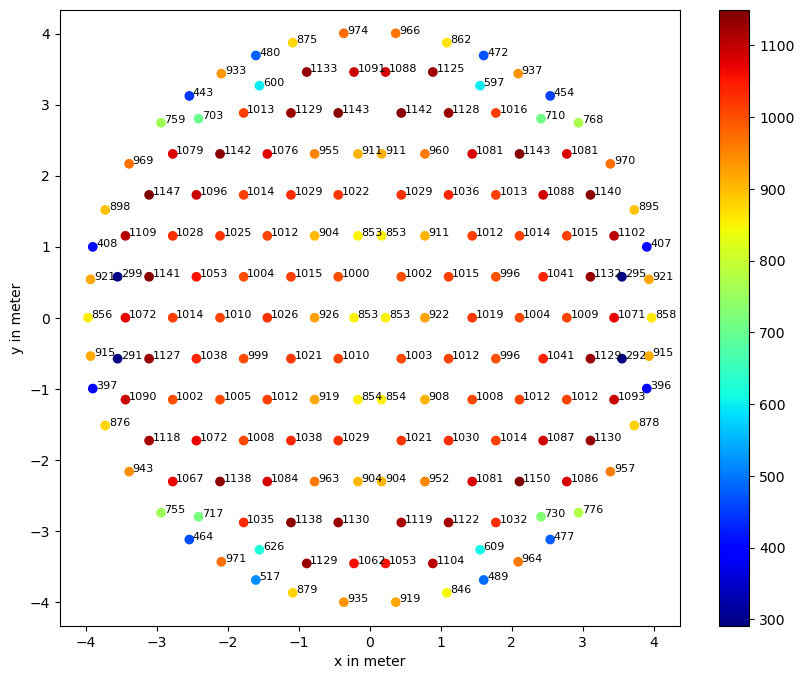

In [52]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(sax, say, c=f_corr)
plt.colorbar()
plt.axis('equal')
for i in range(len(sax)):
    plt.text(sax[i]+.05, say[i], '%.0f'%f_corr[i],color='k',fontsize=8)
plt.xlabel('x in meter')
plt.ylabel('y in meter')